Water Shed Segmentation

In geographical sense : An array where water accumulates. It is a land area that channels / drains rain and snow to 
creeks, streams, etc. Watershed can be segmented as topographical maps with boundaries (more lowers the altitude of the land, more water it accumulates). The brightness determines the high in this algorithm.

It works by filling values (i.e local minima), with pixels belonging to the same predefined label. High intensity denotes peaks and hills, while low intensity denotes valley. We fill every local isloated minima and mark it as a different segment. We also create a boundary / barrier between two isolated valleys.

The algorithm is useful for segmenting images into background and forground for certain images where other algorithms fail, for example when the forground has several objects of same / similar intensity, other algorithms will determine that all said objects will be merged to one, while the watershed algorithm prevents this.

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

source image


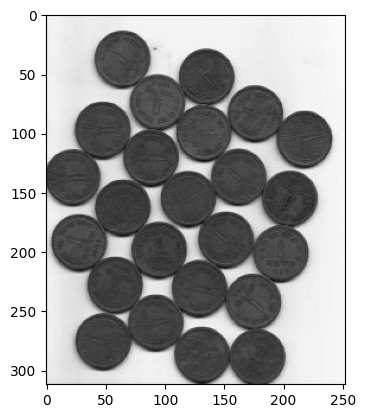

In [61]:
image = cv2.imread('../data/coins.jpg')
color_image = image.copy()

image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print('source image')
plt.imshow(image, cmap='gray')
plt.show()

Performing threshold based segmentation

threshold segmented image


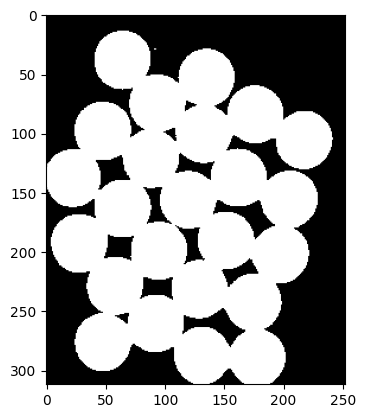

In [62]:
threshold_image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

print('threshold segmented image')
plt.imshow(threshold_image, cmap='gray')
plt.show()

Noise Removal using morphological opening, and dilation to make pixels around boundaries thinner (to now surely what is background)

mophological opening


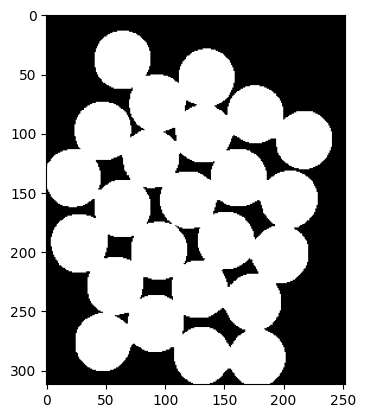

dilation


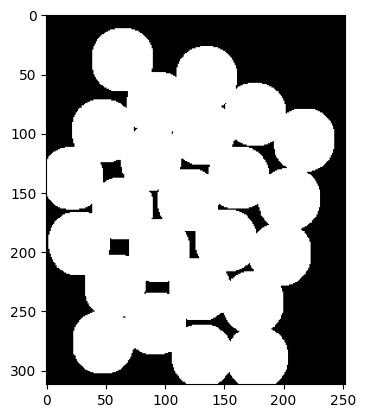

In [63]:
opening = cv2.morphologyEx(threshold_image, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8), iterations=3)
print('mophological opening')
plt.imshow(opening, cmap='gray')
plt.show()

dilation = cv2.dilate(opening, np.ones((3, 3), dtype=np.uint8), iterations=2)
print('dilation')
plt.imshow(dilation, cmap='gray')
plt.show()

Distance Transform : As pixels get further away from a bunch of 0's, the intensity increnases. Essentially, the edges are darker, while the center of object is bright.

Distance transform


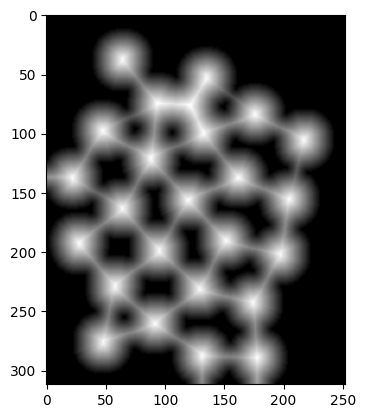

forground points (sure)


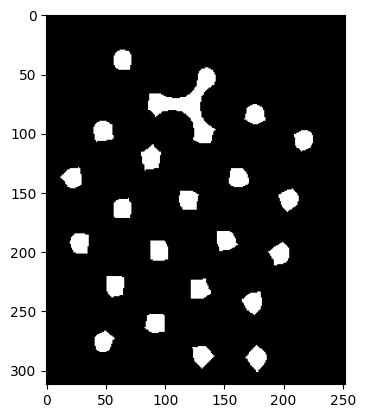

unknown


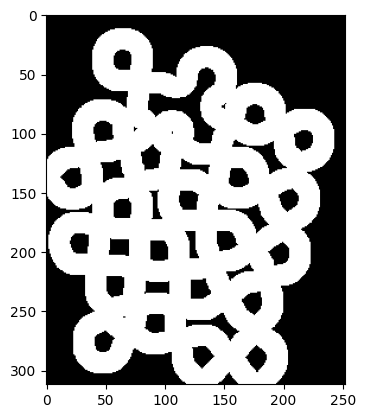

In [64]:
dist_transform = cv2.distanceTransform(dilation, cv2.DIST_L2, 5)
forground = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)[1]
print('Distance transform')
plt.imshow(dist_transform, cmap='gray')
plt.show()

print('forground points (sure)')
plt.imshow(forground, cmap='gray')
plt.show()

# Not sure if forground or background
print('unknown')
unknown_region = cv2.subtract(dilation, np.uint8(forground))
plt.imshow(unknown_region, cmap='gray')
plt.show()

Find connected componenets and get markers for each connected component

markers


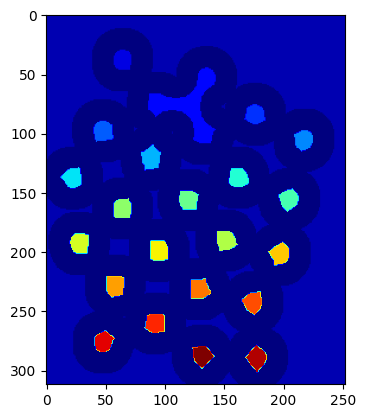

In [65]:
markers = cv2.connectedComponents(np.uint8(forground))[1]

# Plus one so background is 0, not 1
markers=markers+1

# Mark unknown region (not sure if forground or background) with 0's
markers[unknown_region==255] = 0

print('markers')
plt.imshow(markers, cmap='jet')
plt.show()

Using the final watershed algorithm

markers


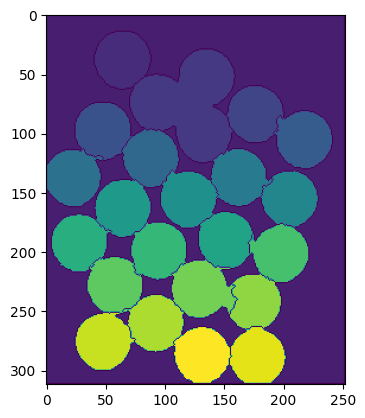

watershed res


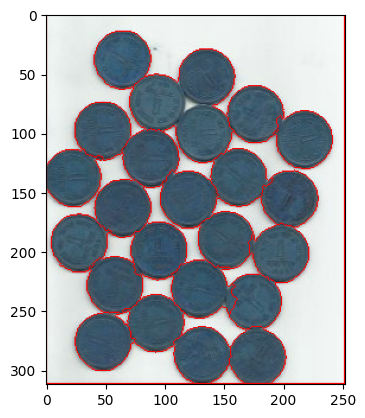

In [66]:
watershed_res = cv2.watershed(color_image, markers)

# Make boundaries (marked with -1 as background)
color_image[markers==-1] = [255, 0, 0]

print('markers')
plt.imshow(markers)
plt.show()

print('watershed res')
plt.imshow(color_image)
plt.show()